# Data Validation
After downloading the csv file and checking the columns values I saw that dataset contains 1500 rows and 8 columns.
I have validated all columns values with their criteria:
- booking_id has **no missing values** and same as description.
- months_as_member has **no missing values** and same as desctiption.
- weight has **20 missing values**, replaced them with average weight, all else is same as description.
- days_before has **no missing values**, but **object class**, while should be int, replaced string values to integer, converted to integer.
- day_of_week has **no missing values**, but values has **different words for same values**, so replaced duplicate values, converted to categorical.
- time has **no missing values** and same as description, converted to categorical.
- category has **no missing values**, but has **wrong values** '-', replaced them with 'unknown', converted to categorical.
- attended has **no missing values** and is same as description, converted to boolean.

## Initial data before cleaning

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import the csv file and check the columns
df = pd.read_csv('https://s3.amazonaws.com/talent-assets.datacamp.com/fitness_class_2212.csv')
df.info()
for col in df.columns:
    print(df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        1500 non-null   int64  
 1   months_as_member  1500 non-null   int64  
 2   weight            1480 non-null   float64
 3   days_before       1500 non-null   object 
 4   day_of_week       1500 non-null   object 
 5   time              1500 non-null   object 
 6   category          1500 non-null   object 
 7   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB
[   1    2    3 ... 1498 1499 1500]
[ 17  10  16   5  15   7  11   9  23  13   8  22   6  33  24  14   2  12
  26  28  27   1   3  21  18  19  53  20  34  25  32  73  55   4  35  54
  76  62  42 105  90  29  60  30 107  52  37  38  48  51  40  89  57  36
  44  39  41  47  58  66  45  43  61  50  65  31  97  59  93 148 111  69]
[79.56 79.01 74.53 ... 87.38 68.

## Data after cleaning and removing missing values

In [10]:
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['days_before'] = df['days_before'].str.removesuffix(' days').astype('int64')
df['day_of_week'] = df['day_of_week'].replace('Wednesday', 'Wed').replace('Fri.', 'Fri').replace('Monday', 'Mon').astype('category')
df['time'] = df['time'].astype('category')
df['category'] = df['category'].replace('-', 'unknown').astype('category')
df['attended'] = df['attended'].astype('bool')
df.info()
for col in df.columns:
    print(df[col].unique())
# all wrong or missing values were replaced #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   booking_id        1500 non-null   int64   
 1   months_as_member  1500 non-null   int64   
 2   weight            1500 non-null   float64 
 3   days_before       1500 non-null   int64   
 4   day_of_week       1500 non-null   category
 5   time              1500 non-null   category
 6   category          1500 non-null   category
 7   attended          1500 non-null   bool    
dtypes: bool(1), category(3), float64(1), int64(3)
memory usage: 53.5 KB
[   1    2    3 ... 1498 1499 1500]
[ 17  10  16   5  15   7  11   9  23  13   8  22   6  33  24  14   2  12
  26  28  27   1   3  21  18  19  53  20  34  25  32  73  55   4  35  54
  76  62  42 105  90  29  60  30 107  52  37  38  48  51  40  89  57  36
  44  39  41  47  58  66  45  43  61  50  65  31  97  59  93 148 111  69]
[79.56 79.01

# Data Exploration
**Graph 1** shows that most of the observation of attended are False. True observations account for 30% of attended observations. The data is **mildly unbalanced**.

**Graph 2** shows that months as member values are distributed **between 0 to 40** months with outliers from 40 to 140. The outliers can **cause problems** for fitting machine learning model, so they should be dealt with. I **capped the outliers** value to maximum of 40, to save the events, but not to affect the mean. **Graph 3** shows new distribution of values. 

**Graph 4** shows **positive relationship** between attended and months as member variables.

## Inspecting bookings attended variable

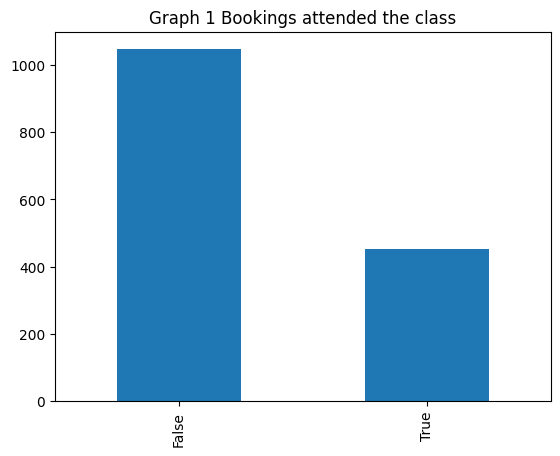

In [11]:
df['attended'].value_counts().plot(kind = 'bar')
plt.title('Graph 1 Bookings attended the class')
plt.show()

## Inspecting months as member variable

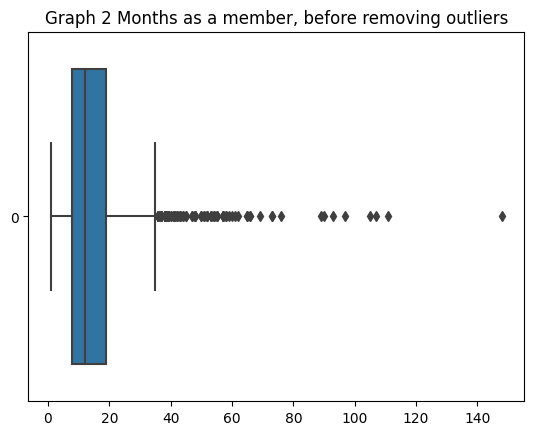

In [12]:
sns.boxplot(df['months_as_member'], orient= 'h')
plt.title('Graph 2 Months as a member, before removing outliers')
plt.show()

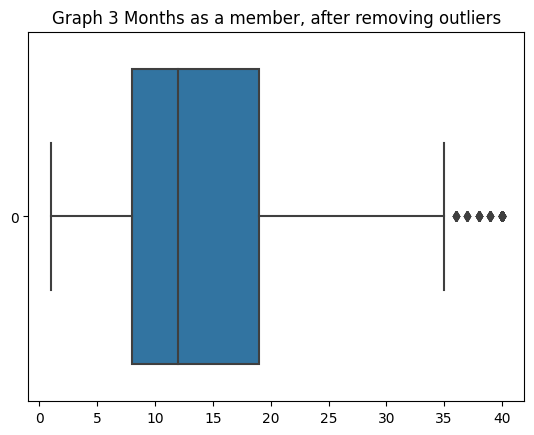

In [13]:
df['months_as_member'][df['months_as_member'] > 40] = 40
sns.boxplot(df['months_as_member'], orient= 'h')
plt.title('Graph 3 Months as a member, after removing outliers')
plt.show()

## Inspecting relationship between attended and months as member variables

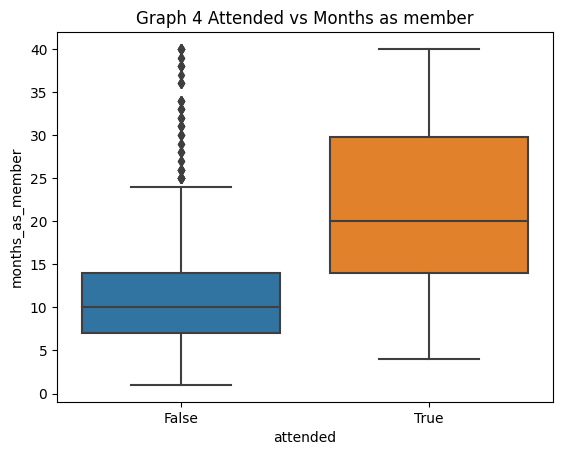

In [14]:
sns.boxplot(data = df, x = 'attended', y = 'months_as_member')
plt.title('Graph 4 Attended vs Months as member')
plt.xlabel('attended')
plt.ylabel('months_as_member')
plt.show()

# Model fitting
Since we need to predict categorical variable, **classification model** will be used. To make prediction for binary variable I will use **logistic regression** as baseline model, since it was designed for this task, and **Decision tree classifier** as a comparison, because it too is good for binary classification, but less affected by outliers and deals better with unbalanced data.

## Prepare data for modeling

In [15]:
X = df.drop(['booking_id','attended'], axis = 1)
X = pd.get_dummies(X, drop_first= True).to_numpy()
y = df['attended'].replace({True:1,False:0}).values.reshape(1500, 1)

## Split data into train and test datasets

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
X = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 228)

## Model 1 Logistic Regression

In [17]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

## Model 2 Decision tree

In [18]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

# Model evaluation
To evaluate a classification model the best metrics can be seen on Classification report. GoalZone wants to predict if member **will not attend** the class, so the important predictions are true 0 values. Therefore Recall is a good estimate of models performance. We can see that Logistic Regression has **recall value of 94%** for false 'attended' event, while decision tree **recall is 75%**.

From this we can assume that **Logistic Regression** is better to predict whether member will not attend the class,  so that GoalZone can make another spaces available.

## Logistic regression evaluation

In [19]:
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

[[246  17]
 [ 76  36]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       263
           1       0.68      0.32      0.44       112

    accuracy                           0.75       375
   macro avg       0.72      0.63      0.64       375
weighted avg       0.74      0.75      0.72       375



## Decision tree evaluation

In [20]:
print(confusion_matrix(y_test, y_pred_clf))
print(classification_report(y_test, y_pred_clf))

[[196  67]
 [ 44  68]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       263
           1       0.50      0.61      0.55       112

    accuracy                           0.70       375
   macro avg       0.66      0.68      0.66       375
weighted avg       0.72      0.70      0.71       375

